In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn

%matplotlib inline

from utils import tokenizer, colouring
from wordcloud import WordCloud
import nltk
from nltk import FreqDist

In [2]:
lyrics = pd.read_csv("data/lyrics.csv")

# load some bands to focus on
with open("data/artists.txt", "r") as f:
    bands = f.read().strip().replace('"', "").split("\n")
    f.close()
    
lyrics = lyrics[lyrics.band_name.isin(bands)].copy()    

# Define the Markov Chain Class 

In [3]:
START_OF_SEQ = "~"
END_OF_SEQ = "[END]"

import random
import json

class MarkovChain:
    """
    Simple Markov Chain Class
    """

    def __init__(self, order=1, pad=True, records=None):
        """
        Initialise Markov chain
        :param order: int - number of tokens to consider a state
        :param pad: bool - whether to pad training strings with start/end tokens
        """
        self.order = order
        self.pad = pad
        self.records = {} if records is None else records

    def add_tokens(self, tokens):
        """
        Adds a list of tokens to the markov chain

        :param tokens: list of tokens
        :return: None
        """
        if self.pad:
            tokens = [START_OF_SEQ] * self.order + tokens + [END_OF_SEQ]

        for i in range(len(tokens) - self.order):
            current_state = tuple(tokens[i:i + self.order])
            next_state = tokens[i + self.order]
            self.add_state(current_state, next_state)

    def add_state(self, current_state, next_state):
        """
        Updates the weight of the transition from current_state to next_state
        with a single observation.

        :param current_state: tuple - current state
        :param next_state: token - the next observed token
        :return: None
        """
        if current_state not in self.records.keys():
            self.records[current_state] = dict()

        if next_state not in self.records[current_state].keys():
            self.records[current_state][next_state] = 0

        self.records[current_state][next_state] += 1

    def generate_sequence(self, n=100, initial_state=None):
        """
        Generates a sequence of tokens from the markov chain, starting from
        initial_state. If initial state is empty, and pad is false it chooses an
        initial state at random. If pad is true,

        :param n: int - The number of tokens to generate
        :param initial_state: starting state of the generator
        :return: list of generated tokens
        """

        if initial_state is None:
            if self.pad:
                sequence = [START_OF_SEQ] * self.order
            else:
                sequence = list(random.choice(self.records.keys()))
        else:
            sequence = initial_state[:]

        for i in range(n):
            current_state = tuple(sequence[-self.order:])
            next_token = self.sample(current_state)
            sequence.append(next_token)

            if next_token == END_OF_SEQ:
                return sequence

        return sequence

    def sample(self, current_state):
        """
        Generates a random next token, given current_state
        :param current_state: tuple - current_state
        :return: token
        """

        possible_next = self.records[current_state]
        n = sum(possible_next.values())

        m = random.randint(0, n)
        count = 0
        for k, v in possible_next.items():
            count += v
            if m <= count:
                return k

    def save(self, filename):
        """
        Saves Markov chain to filename

        :param filename: string - where to save chain
        :return: None
        """
        with open(filename, "w") as f:
            m = {
                "order": self.order,
                "pad": self.pad,
                "records": {str(k): v for k, v in self.records.items()}
            }
            json.dump(m, f)

    @staticmethod
    def load(filename):
        """
        Loads Markov chain from json file
        
        DUE TO USE OF EVAL
        DO NOT RUN THIS ON UNTRUSTED FILES
        
        :param filename: 
        :return: MarkovChain
        """
        with open(filename, "r") as f:
            raw = json.load(f)

        mc = MarkovChain(
            raw["order"], 
            raw["pad"], 
            {eval(k):v for k,v in raw["records"].items()}
        )
        
        return mc

In [4]:
notb = lyrics[lyrics.song_name == " The Number Of The Beast"].lyrics.values[0]
print(notb)


"Woe to you, Oh Earth and Sea, for the Devil sends the
beast with wrath, because he knows the time is short...
Let him who hath understanding reckon the number of the
beast for it is a human number, its number is Six hundred and
sixty six."

I left alone my mind was blank
I needed time to think to get the memories from my mind

What did I see can I believe that what I saw
that night was real and not just fantasy

Just what I saw in my old dreams were they
reflections of my warped mind staring back at me

'Cos in my dream it's always there the evil face that twists my mind
and brings me to despair

The night was black was no use holding back
'Cos I just had to see was someone watching me
In the mist dark figures move and twist
Was this all for real or some kind of hell
666 the number of the beast
Hell and fire was spawned to be released

Torches blazed and sacred chants were praised
As they start to cry hands held to the sky
In the night the fires burning bright
The ritual has begun Sa

In [5]:
mc_1_word_notb = MarkovChain(1, pad=False)
mc_1_word_notb.add_tokens(tokenizer.tokenize_strip_non_words(notb)[71:127])

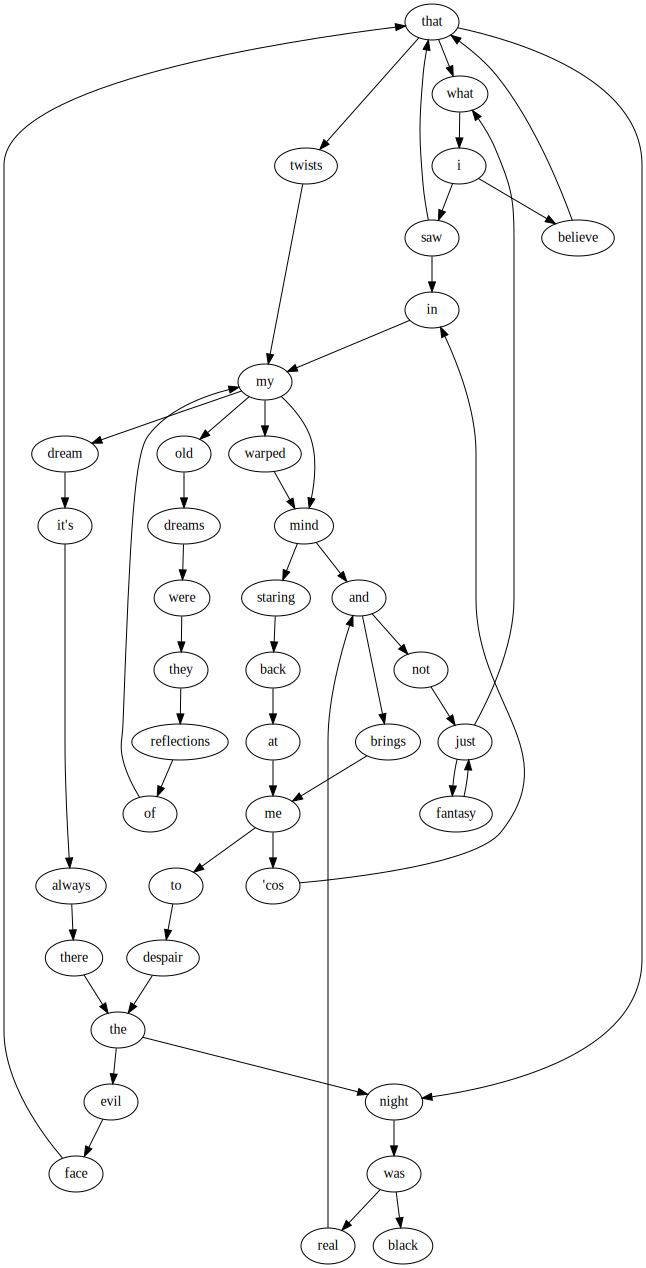

In [6]:
import graphviz
gv = graphviz.Digraph(engine="dot", format="png")

for n, e in mc_1_word_notb.records.items():
    gv.node(n[0])
    for k,v in e.items():
        gv.edge(n[0], k)
        
gv.render("resources/666")

gv

# Full Training 

In [7]:
mc_4_words = MarkovChain(4, pad=True)

for s in lyrics.lyrics.values:
    mc_4_words.add_tokens(tokenizer.tokenize_words(s))

In [25]:
full_text = tokenizer.normalise("".join(lyrics.lyrics.values))

def is_in_lyrics(s):
    return s in full_text

def colour_based_on_existance(s):
    col = colouring.ColourIter()

    n = len(s)
    start = 0
    end = 1
    completed = []

    while end < n:
        if not is_in_lyrics(s[start:end]):
            completed.append(colouring.colour_text_background_html(s[start:end], col()))
            start = end
        else:
            end += 1
        
    completed.append(colouring.colour_text_background_html(s[start:], col()))
        
    return completed

from IPython.core.display import display, HTML

In [27]:
samp = tokenizer.tokenized_pretty_print(mc_4_words.generate_sequence(n=200))

htmled = "<p>{}</p>".format("".join(colour_based_on_existance(samp)).replace("\n", "<br>"))

display(HTML(htmled))

In [29]:
print(htmled)

<p><span style="color:#ff7f0e">~</span><span style="color:#2ca02c"> ~</span><span style="color:#d62728"> ~</span><span style="color:#9467bd"> ~</span><span style="color:#8c564b"> legion of the damned<br><br>n</span><span style="color:#e377c2">ow it's over<br>now it's over<br>and i</span><span style="color:#7f7f7f">t just ain't right. it just ain't right </span><span style="color:#bcbd22">hey man, look at me, l</span><span style="color:#17becf">ook at me<br>you know i</span><span style="color:#1f77b4">t won't last too long hey kid, you're the toast of the town<br><br></span><span style="color:#ff7f0e">what did i ever do to you<br>t</span><span style="color:#2ca02c">hat makes you fall much higher<br>you plant a d</span><span style="color:#d62728">emon seed<br>you raise a flower of fire.<br>we see them n</span><span style="color:#9467bd">ow in picture books<br>built by you on belfast docks<br>the greatest ships the world has ever seen.</span><span style="color:#8c564b"><br>sing this hymn 